# State Farm Distracted Driver Detection

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [5]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [6]:
#path = "data/"
path = "data/sample/"

A few basic libraries that we'll need for the initial exercises:

In [7]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [15]:
import utils; reload(utils)
from utils import plots

# Create a VGG model from scratch in Keras

For the rest of this tutorial, we will not be using the Vgg16 class at all. Instead, we will recreate from scratch the functionality we just used. This is not necessary if all you want to do is use the existing model - but if you want to create your own models, you'll need to understand these details. It will also help you in the future when you debug any problems with your models, since you'll understand what's going on behind the scenes.

## Model setup

We need to import all the modules we'll be using from numpy, scipy, and keras:

In [16]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [17]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [18]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [21]:
def vgg_preprocess(x):
    return x

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [22]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

In [23]:
model = VGG_16()

## Getting Image Net predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [24]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [25]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

From here we can use exactly the same steps as before to look at predictions from the model.

Found 200 images belonging to 10 classes.


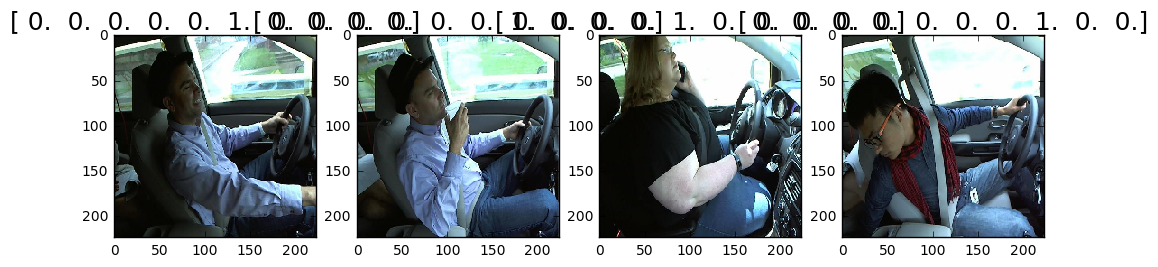

In [27]:
batches = get_batches('train', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [38]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [43]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.2762e-08   2.3712e-10   3.3695e-09   2.4646e-09   9.4356e-10]

Predictions prob/class: 
  0.6345/German_shepherd
  0.2317/Shetland_sheepdog
  0.1761/Australian_terrier
  0.4375/American_Staffordshire_terrier
